In [1]:
#required libraris 
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold

In [3]:
#number of splits for kfolds
no_of_splits=5

In [4]:
# read the from the file and return the dataframe
def readFromTheFile(fileName):
    datasetDataFrame = pd.read_csv(fileName)
    return datasetDataFrame

# display the info of the dataset
def infoAboutDataset(datasetFrame):
    print("Decription of the columns")
    print(datasetFrame.info())
    print()
    print("Description of the dataset")
    print(datasetFrame.describe())
    print("Head of the dataset")
    print(datasetFrame.head())

# split the dataset into x and y
def convertDataFrameIntoXandY(datasetDataFrame, columnx, columny):
    x = datasetDataFrame[columnx].to_numpy()
    y = datasetDataFrame[columny].to_numpy()
    return x, y

# vfscore of the column
def returVfScore(X):
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(
        X.values, i) for i in range(len(X.columns))]
    return vif_df

# return standard Error
def returnStandardError(x, mean_res_sq):
    meanValue = x.mean(axis=0)
    SD_features = []
    for i in range(x.shape[1]):
        col = x[:, i]
        mean = meanValue[i]
        diff_from_mean = col - mean
        sq_x = np.dot(diff_from_mean.T, diff_from_mean)
        SD_features.append(math.sqrt(mean_res_sq/sq_x))
    return SD_features

# return t values
def returnTValues(w, se):
    tStats = [i[0]/j for i, j in zip(w, se)]
    return tStats

# return of the correlation matrix
def returnCoreelationMatric(x):
    return np.corrcoef(x.T)


# analysis of the coffecients
def coffecientAnalysis(w, x, y, b):
    # residual_squared =mean_squared_error(y, np.dot(x,w)+b)*x.shape[0]
    # mean_res_sq = residual_squared/(x.shape[0]-2)
    print("==========================================================")
    print("Mean square error of  Regression")
    print(returnMeanSqaure(w, b, x, y))
    # se=returnStandardError(x,mean_res_sq)
    print("==========================================================")
    print("Standard Error of the coffecients")
    # print(se)
    # print("==========================================================")
    # print("T values ")
    # print(returnTValues(w,se))

#minmax normalization
def minMaxNormalization(x, y):
    max_value = x.max(axis=0)
    min_value = x.min(axis=0)
    for i in range(0, x.shape[0]):
        for j in range(0, x.shape[1]):
            x[i][j] = (x[i][j]-min_value[j])/(max_value[j]-min_value[j])
            x[i][j] = x[i][j]/100000000000000

    max_value = y.max(axis=0)
    min_value = y.min(axis=0)
    for i in range(0, y.shape[0]):
        y[i] = (y[i]-min_value)/(max_value-min_value)
        y[i]=y[i]/100000000000000

    return x, y




# linear regression method
def fitlinearRegression(x, y, numberOfEpochs, learningRate):
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    y=np.expand_dims(y,axis=1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*np.dot(x.T, (yPredict-y))
        db = (1/x.shape[0])*np.sum(yPredict-y)
        w = w - (learningRate*dw)
        b = b - (learningRate*db)
    return w, b


# ridge regression method
def fitRidgeRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    y=np.expand_dims(y,axis=1)
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*w)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*b)
        w = w - (learningRate*dw)
        b = b - (learningRate*db)
    return w, b


# Lasso regression method
def fitLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    y=np.expand_dims(y,axis=1)
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*(w/abs(w)))
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))

    return w, b


# Elastic regression method
def fitElasticLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate):
    y=np.expand_dims(y,axis=1)
    w = np.random.rand(x.shape[1], 1)
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+lambdaValue*(w/abs(w))+lambdaValue*w)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+lambdaValue*(b/abs(b))+lambdaValue*b)
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))

    return w, b

# graph lasso regression method
def graphLassoRegression(x, y, numberOfEpochs, lambdaValue, learningRate, priorrmatrix):
    y=np.expand_dims(y,axis=1)
    correlationMatrix = returnCoreelationMatric(x)
    w = np.random.rand(x.shape[1], 1)
    penalty = np.zeros((x.shape[1], 1))
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        for k in range(0, x.shape[1]):
            derv1 = 0
            derv2 = 0
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv2 = derv2+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv2 = derv2-(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            penalty[k][0] = 2*(derv1-derv2)
            penalty[k][0] = (1-lambdaValue)*(abs(w[k][0])/w[k]
                                             [0])+(lambdaValue*penalty[k][0])
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+penalty)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+(1-lambdaValue)*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))
    return w, b


#  new approach for regression CGFLASSO
def fitNewApproach(x, y, numberOfEpochs, lambdaValue, learningRate, priorrmatrix):
    y=np.expand_dims(y,axis=1)
    correlationMatrix = returnCoreelationMatric(x)
    for i in range(0, x.shape[1]):
        for j in range(0, x.shape[1]):
            # priorrmatrix[i][j] = priorrmatrix[i][j]/(1+(priorrmatrix[i][j]-abs(correlationMatrix[i][j])))
            weightLambda = abs(
                priorrmatrix[i][j])/(1+abs((priorrmatrix[i][j]-correlationMatrix[i][j])))
            priorrmatrix[i][j] = (weightLambda*priorrmatrix[i][j]) + \
                ((1-weightLambda)*correlationMatrix[i][j])

    w = np.random.rand(x.shape[1], 1)
    penalty = np.zeros((x.shape[1], 1))
    b = np.random.rand(1, 1)
    for i in range(0, numberOfEpochs):
        yPredict = np.dot(x, w)+b
        for k in range(0, x.shape[1]):
            derv1 = 0
            derv2 = 0
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv1 = derv1+(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            for l in range(0, x.shape[1]):
                if correlationMatrix[k][l] >= 0:
                    derv2 = derv2+(priorrmatrix[k][l]*(w[k][0]-w[l][0]))
                else:
                    derv2 = derv2-(priorrmatrix[k][l]*(w[k][0]+w[l][0]))
            penalty[k][0] = 2*(derv1-derv2)
            penalty[k][0] = (1-lambdaValue)*(abs(w[k][0])/w[k]
                                             [0])+(lambdaValue*penalty[k][0])
        dw = (1/x.shape[0])*(np.dot(x.T, (yPredict-y))+penalty)
        db = (1/x.shape[0])*(np.sum(yPredict-y)+(1-lambdaValue)*(b/abs(b)))
        w = w - (learningRate*(dw))
        b = b - (learningRate*(db))
    return w, b


# def for single run
def singleRunAnalysis(x, y, w, b):
    print("==========================================================")
    print("Coffecients")
    print(w)
    coffecientAnalysis(w, x, y, b)


# return mean square error
def returnMeanSqaure(w, b, x, y):
    yPredict = np.dot(x, w)+b
    return np.sum((yPredict-y)**2)/(2*x.shape[0])


In [5]:
df=pd.read_csv('./findataset.csv')

In [6]:
df.describe()

,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),S_Close(t-2),...,QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast
count,3732.000000,3732.000000,3732.000000,3732.000000,3.732000e+03,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,...,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000,3732.000000
mean,87.199989,88.093232,86.335801,87.256589,1.143350e+08,2.639050,91.457990,80.901789,87.135107,87.015758,...,87.882907,87.573303,86.677655,1802.140268,1801.554293,1799.223352,16115.084448,16110.365965,16091.619116,87.377980
std,79.017999,79.952065,78.265419,79.189743,9.931555e+07,3.237696,82.563527,72.153572,78.965148,78.749784,...,55.901003,55.530655,54.491380,649.993978,649.562660,647.877979,5605.625910,5603.116874,5593.480623,79.412983
min,6.390000,6.530000,6.190000,6.260000,1.136200e+07,0.106696,6.819677,5.816458,6.260000,6.260000,...,24.048000,24.828500,25.837200,676.530000,676.530000,676.530000,6547.050000,6547.050000,6547.050000,6.260000
25%,22.575000,22.895000,22.160000,22.532500,3.714862e+07,0.794558,23.849436,20.258057,22.505000,22.480000,...,41.364500,41.257750,41.123750,1288.135000,1288.057500,1287.237500,11667.017500,11659.415000,11642.605000,22.555000
50%,67.140000,67.650000,66.490000,67.075000,8.545600e+07,1.614071,70.236249,62.773827,67.040000,67.015000,...,63.588500,63.528750,62.747100,1554.465000,1554.050000,1552.540000,14455.550000,14453.670000,14434.390000,67.115000
75%,117.555000,118.350000,116.730000,117.650000,1.603878e+08,3.056257,121.841177,112.698250,117.587500,117.442500,...,114.288000,114.276500,113.690500,2202.025000,2199.537500,2190.382500,19103.825000,19086.860000,18908.630000,117.682500
max,457.720000,464.170000,455.710000,460.040000,8.432424e+08,33.532634,479.279768,364.702427,454.790000,454.790000,...,270.255000,265.454000,255.044600,3386.150000,3386.150000,3386.150000,29551.420000,29551.420000,29551.420000,460.040000


In [7]:
#changing categorical value to the ordinary encoding
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(df)
encoder = OrdinalEncoder()
for col in df.select_dtypes(include='O').columns:
    df[col] = encoder.fit_transform(df[[col]])

In [8]:
# VfScore of all the column
print(returVfScore(df.drop(['Close_forcast'], axis=1)))

/home/mohan/.local/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


             feature           VIF
0               Open  1.229586e+04
1               High  1.835960e+04
2                Low  1.476906e+04
3           Close(t)  5.362337e+05
4             Volume  3.778182e+00
5               SD20           inf
6         Upper_Band           inf
7         Lower_Band           inf
8       S_Close(t-1)  1.889350e+05
9       S_Close(t-2)  5.700510e+04
10      S_Close(t-3)  1.256235e+04
11      S_Close(t-5)  1.323052e+04
12       S_Open(t-1)  5.002242e+03
13               MA5  4.596310e+05
14              MA10  2.034905e+05
15              MA20           inf
16              MA50  2.542943e+04
17             MA200  1.938365e+02
18             EMA10           inf
19             EMA20           inf
20             EMA50           inf
21            EMA100           inf
22            EMA200           inf
23              MACD  2.785596e+03
24          MACD_EMA  1.852582e+03
25               ATR  3.260558e+01
26               ADX  1.687794e+00
27               ROC

In [9]:
columnNames = df.columns

In [10]:
numberOfColumns = df.shape[1]

In [11]:
#normalizing the dataset
x, y = convertDataFrameIntoXandY(
    df,columnNames[:numberOfColumns-1] , columnNames[numberOfColumns-1])
x, y = minMaxNormalization(x, y)


In [12]:
#spliting the dataset into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [13]:
#initlization of the Kfold object
kf = KFold(n_splits=no_of_splits)

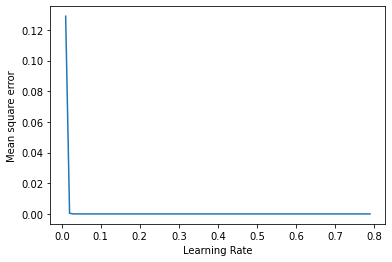

In [14]:
#finding the optimal hyperparamter that is learning rate for OLS
learning_rate = [i/100 for i in range(1, 80)]
merror = []
for i in learning_rate:
  error=0
  for training_index, testing_index in kf.split(x_train):
    X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
    Y_train, Y_test = y_train[training_index] , y_train[testing_index]
    w, b = fitlinearRegression(X_train, Y_train, 300, i)
    error=error+returnMeanSqaure(w, b, X_test, Y_test)
  merror.append(error/no_of_splits)


plt.plot(learning_rate, merror)
plt.xlabel("Learning Rate")
plt.ylabel("Mean square error")
plt.show()


In [22]:
#getting the mse on test dataset on the optimal hyperparameter
w, b = fitlinearRegression(x_train, y_train, 300, 0.03)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameter
for _ in range(100):
    w, b = fitlinearRegression(x_train, y_train, 300, 0.03)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[0.35630879]
 [0.41998041]
 [0.12218527]
 [0.15705607]
 [0.26559252]
 [0.02144761]
 [0.67508514]
 [0.98392653]
 [0.27232397]
 [0.44194798]
 [0.20231113]
 [0.49813753]
 [0.77744109]
 [0.77444182]
 [0.80276632]
 [0.56672611]
 [0.27588484]
 [0.25600613]
 [0.6069532 ]
 [0.12459413]
 [0.57071297]
 [0.77625357]
 [0.66898202]
 [0.38245889]
 [0.54023568]
 [0.49264276]
 [0.63767043]
 [0.06983097]
 [0.3471254 ]
 [0.37904423]
 [0.1175847 ]
 [0.95060927]
 [0.53300885]
 [0.31650705]
 [0.20931093]
 [0.6426829 ]
 [0.28132488]
 [0.12531589]
 [0.8921711 ]
 [0.51228265]
 [0.39184928]
 [0.65719844]
 [0.91739689]
 [0.53088931]
 [0.41481234]
 [0.10713175]
 [0.67986405]
 [0.51854218]
 [0.39332643]
 [0.69137892]
 [0.68705433]
 [0.10189157]
 [0.15369334]
 [0.74872941]
 [0.39038615]
 [0.62842181]
 [0.44378293]
 [0.46221375]
 [0.95311009]
 [0.11389954]]
Mean square error of  Regression
1.0404321453046888e-06
Standard Error of the coffecients
0.28154801788556766
0.30885661177536244
0.306874701275906

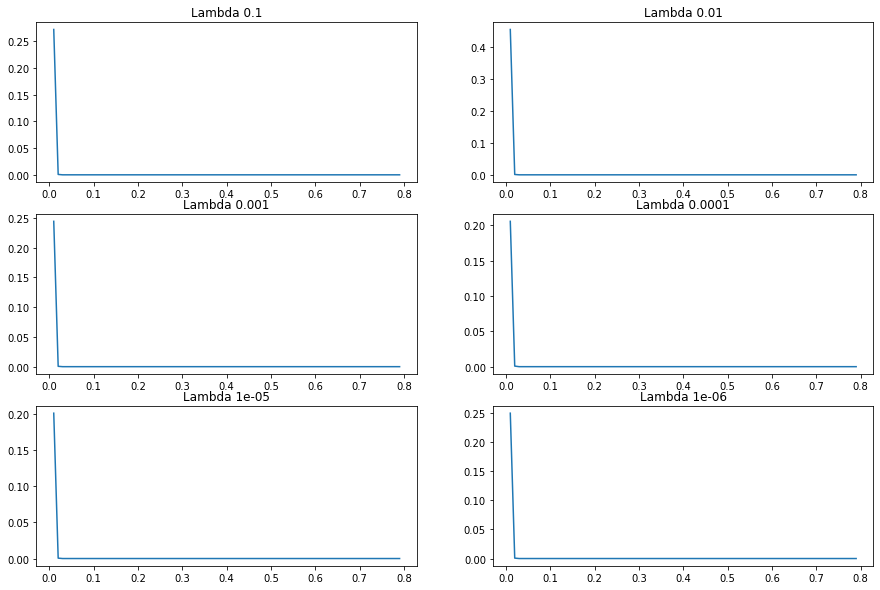

In [23]:
#finding the optimal hyperparamter that is learning rate and regularization constant for ridge regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitRidgeRegression(X_train, Y_train, 300, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)



    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()

In [27]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitRidgeRegression(x_train, y_train, 300, 0.0001, 0.03)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitRidgeRegression(x_train, y_train, 300, 0.0001, 0.03)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[0.89194084]
 [0.57961087]
 [0.4278399 ]
 [0.38526895]
 [0.03382945]
 [0.70233193]
 [0.75039376]
 [0.63292845]
 [0.24596784]
 [0.5694576 ]
 [0.14883307]
 [0.57425335]
 [0.64834213]
 [0.22403453]
 [0.8617191 ]
 [0.5147959 ]
 [0.61740439]
 [0.71925796]
 [0.27875012]
 [0.7469936 ]
 [0.53124859]
 [0.17919574]
 [0.94146953]
 [0.65219519]
 [0.26935285]
 [0.60828029]
 [0.96872264]
 [0.19677049]
 [0.0622813 ]
 [0.10928141]
 [0.42381308]
 [0.08676919]
 [0.61683215]
 [0.81816678]
 [0.18302183]
 [0.69528489]
 [0.57150755]
 [0.13459826]
 [0.86410402]
 [0.18456621]
 [0.53855367]
 [0.0481766 ]
 [0.33544184]
 [0.41053184]
 [0.58845714]
 [0.09017047]
 [0.07346947]
 [0.4528846 ]
 [0.84907845]
 [0.21885046]
 [0.46694093]
 [0.43749839]
 [0.30430936]
 [0.08661892]
 [0.10470036]
 [0.71144879]
 [0.28190633]
 [0.03173025]
 [0.04699548]
 [0.09735817]]
Mean square error of  Regression
2.5520066906439176e-06
Standard Error of the coffecients
0.28677891073510764
0.2825524495402424
0.285225494541325


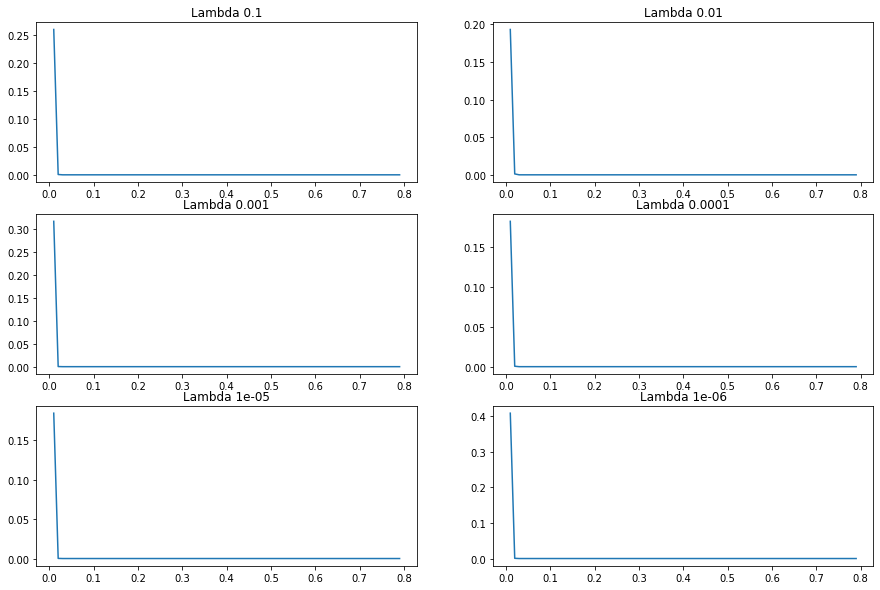

In [28]:
#finding the optimal hyperparamter that is learning rate and regularization constant for lasso regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitLassoRegression(x, y, 300, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()


In [33]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitLassoRegression(x_train, y_train, 300, 0.0001, 0.03)
singleRunAnalysis(x_test, y_test, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitLassoRegression(x_train, y_train, 300, 0.0001, 0.03)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[0.13615346]
 [0.91858772]
 [0.17884707]
 [0.38541844]
 [0.85806612]
 [0.33702806]
 [0.22725491]
 [0.59505697]
 [0.21967393]
 [0.18303011]
 [0.15575287]
 [0.37831818]
 [0.21902483]
 [0.01754801]
 [0.7653048 ]
 [0.68315817]
 [0.51610977]
 [0.43581923]
 [0.5573482 ]
 [0.71690439]
 [0.78819469]
 [0.85729093]
 [0.54422953]
 [0.73959479]
 [0.83918748]
 [0.39129207]
 [0.12158529]
 [0.33046702]
 [0.19282811]
 [0.22766349]
 [0.29072157]
 [0.28602648]
 [0.57372761]
 [0.55740033]
 [0.71997824]
 [0.00390803]
 [0.66117029]
 [0.14325508]
 [0.83096939]
 [0.24747419]
 [0.68903969]
 [0.2057138 ]
 [0.47163977]
 [0.66674431]
 [0.41402138]
 [0.52505892]
 [0.29433047]
 [0.16589487]
 [0.75262328]
 [0.44968918]
 [0.14657225]
 [0.99086711]
 [0.68928178]
 [0.84718681]
 [0.63003952]
 [0.94717684]
 [0.95574963]
 [0.51668228]
 [0.42242259]
 [0.56494695]]
Mean square error of  Regression
1.1128308960691099e-06
Standard Error of the coffecients
0.30326340736409135
0.29280907763180686
0.311068805250337

0.1
0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.01
0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.001
0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 0.41 0.42 0.4

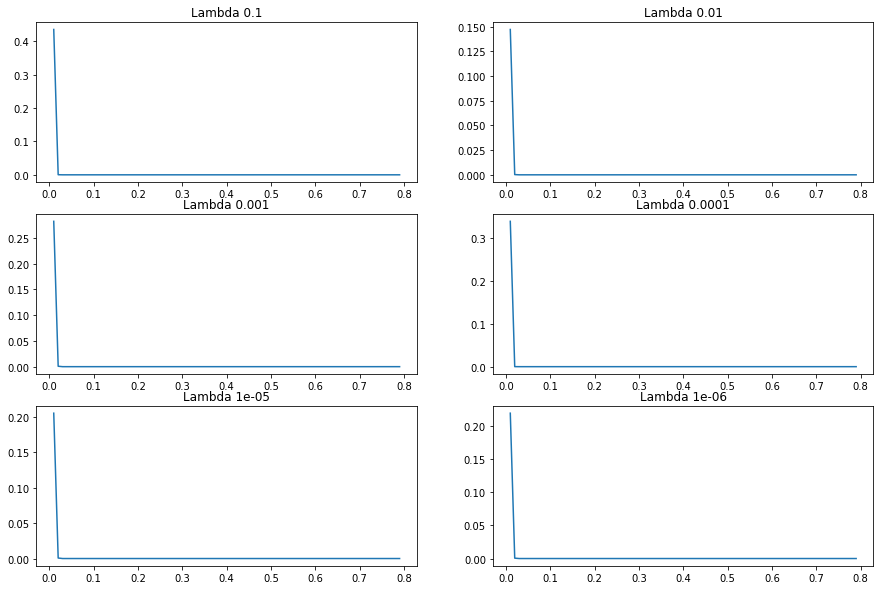

In [120]:
#finding the optimal hyperparamter that is learning rate and regularization constant for graph lasso regression

#building the priormatrix accodring to the Graph lasso research paper 
prioirmatrix = df.corr().to_numpy()
for i in range(0,x_train.shape[1]):
  for j in range(0,x_train.shape[1]):
    if abs(prioirmatrix[i][j])>0.5:
      prioirmatrix[i][j]=1
    else:
      prioirmatrix[i][j]=0



fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    print(j)
    merror = []
    for i in learning_rate:
        print(i,end=" ")
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = graphLassoRegression(x, y, 300, j, i, prioirmatrix)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()

In [121]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = graphLassoRegression(x, y, 300, 0.01, 0.5, prioirmatrix)
singleRunAnalysis(x, y, w, b)


coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = graphLassoRegression(x, y, 300, 0.01, 0.5, prioirmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[0.69398421]
 [0.39501189]
 [0.61839007]
 [0.10026243]
 [0.3312621 ]
 [0.21093036]
 [0.50765986]
 [0.77052719]
 [0.23127707]
 [0.9369246 ]
 [0.00991087]
 [0.29471554]
 [0.15042169]
 [0.02256312]
 [0.46799672]
 [0.17704541]
 [0.02547073]
 [0.82690439]
 [0.90115573]
 [0.54290155]
 [0.64753653]
 [0.48132953]
 [0.60084123]
 [0.65637032]
 [0.53741581]
 [0.42327116]
 [0.92448054]
 [0.30468834]
 [0.43621492]
 [0.36183155]
 [0.419829  ]
 [0.32031813]
 [0.05021682]
 [0.86743951]
 [0.16331148]
 [0.21465551]
 [0.42930924]
 [0.43067373]
 [0.14729615]
 [0.65450017]
 [0.31780314]
 [0.61510373]
 [0.16480581]
 [0.26152524]
 [0.35262522]
 [0.0567531 ]
 [0.30507449]
 [0.16774319]
 [0.54508623]
 [0.46915551]
 [0.46134777]
 [0.64462793]
 [0.28699211]
 [0.41319173]
 [0.37657352]
 [0.79058414]
 [0.4431355 ]
 [0.09023304]
 [0.09658455]
 [0.76914049]]
Mean square error of  Regression
1.4590032154325514e-05
Standard Error of the coffecients
0.2870641459239237
0.2732773398224854
0.2719114883625871


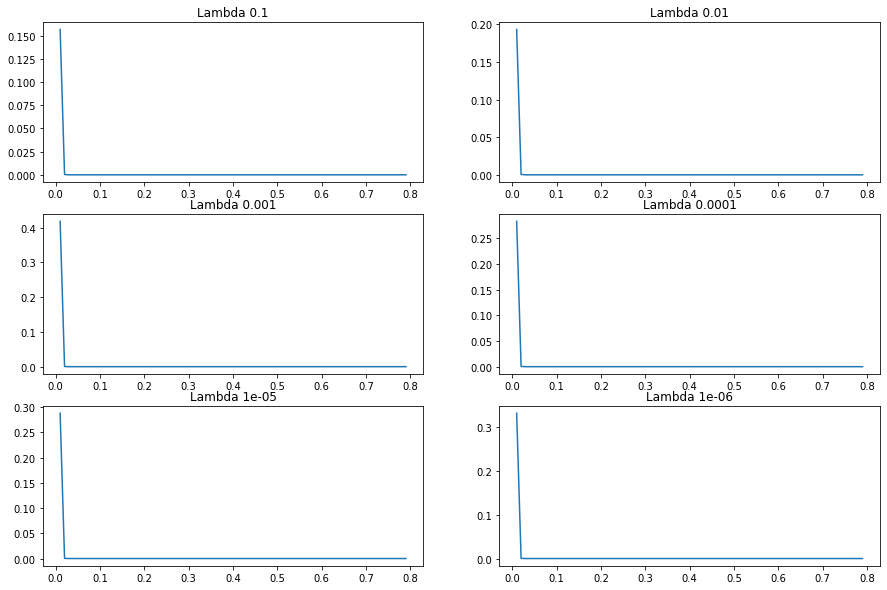

In [122]:
#finding the optimal hyperparamter that is learning rate and regularization constant for Elastic lasso regression
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        error=0
        for training_index, testing_index in kf.split(x_train):
          X_train, X_test = x_train[training_index,:],x_train[testing_index,:]
          Y_train, Y_test = y_train[training_index] , y_train[testing_index]
          w, b = fitElasticLassoRegression(x, y, 300, j, i)
          error=error+returnMeanSqaure(w, b, X_test, Y_test)
        merror.append(error/no_of_splits)

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0


plt.show()


In [123]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitElasticLassoRegression(x, y, 300, 0.1, 0.5)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitElasticLassoRegression(x, y, 300, 0.1, 0.5)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[0.60535723]
 [0.47707725]
 [0.10989703]
 [0.88759431]
 [0.35512481]
 [0.75647089]
 [0.48120214]
 [0.43006746]
 [0.55088145]
 [0.36949095]
 [0.17163691]
 [0.4168004 ]
 [0.82643135]
 [0.06394668]
 [0.28773007]
 [0.7470951 ]
 [0.07137201]
 [0.4790991 ]
 [0.58119577]
 [0.34923969]
 [0.84345806]
 [0.0768057 ]
 [0.27717353]
 [0.34396846]
 [0.26898985]
 [0.47130565]
 [0.32978584]
 [0.493532  ]
 [0.01954981]
 [0.1685821 ]
 [0.15281524]
 [0.09236049]
 [0.74962813]
 [0.57986895]
 [0.8441443 ]
 [0.96342497]
 [0.74656553]
 [0.42102324]
 [0.01263283]
 [0.04462678]
 [0.8226507 ]
 [0.68860595]
 [0.56436448]
 [0.66060172]
 [0.01827926]
 [0.63265524]
 [0.28312736]
 [0.43643048]
 [0.48623455]
 [0.75090087]
 [0.99055217]
 [0.97587244]
 [0.3064378 ]
 [0.6244032 ]
 [0.8806353 ]
 [0.17806478]
 [0.52013889]
 [0.63118829]
 [0.84934128]
 [0.77735701]]
Mean square error of  Regression
1.4886534830341998e-07
Standard Error of the coffecients
0.30717998784879397
0.304121348487657
0.26622372194345556

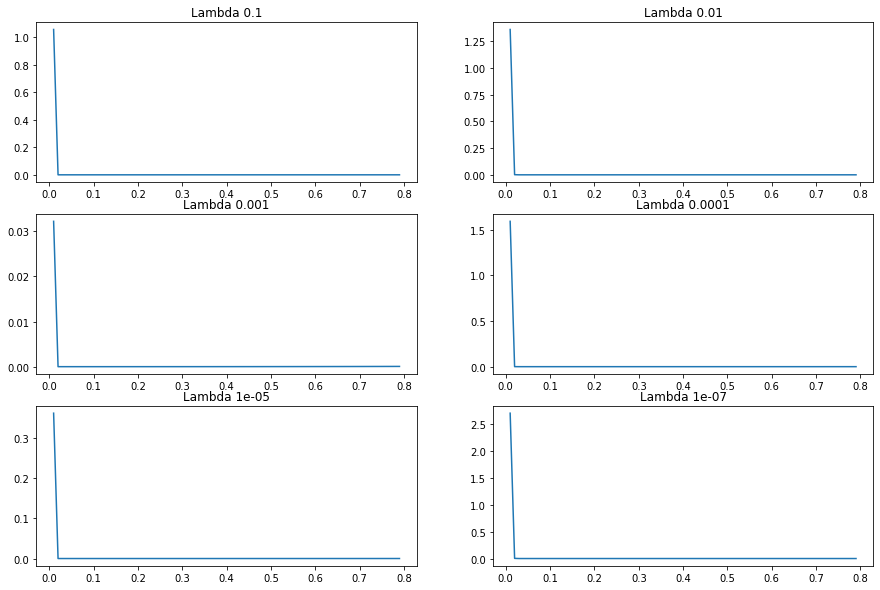

In [124]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix accodring to the knowledge of the domain
pmatrix=[[1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [-0.6, -0.6, -0.6, -0.6, 1.0, -0.4, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.2, -0.2, -0.4, 0.1, -0.1, -0.2, -0.1, -0.1, 0.5, -0.1, -0.2, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.1, -0.7, -0.0, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6], [0.8, 0.8, 0.8, 0.8, -0.4, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.2, 0.2, 0.9, 0.2, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, -0.0, 0.0, 0.0, -0.0, -0.1, -0.1, -0.0, -0.0, 0.0, 0.0, 0.0, 0.2, 0.7, -0.1, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.9, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.9, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.9, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.3, 0.9, 0.1, 0.0, 0.0, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0], [0.5, 0.5, 0.5, 0.5, -0.2, 0.2, 0.4, 0.4, 0.5, 0.5, 0.5, 0.4, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.1, 0.1, 0.4, 0.6, 0.4, 0.4, -0.3, 0.1, 0.7, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.1, 0.3, 0.0, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.5], [0.5, 0.5, 0.5, 0.5, -0.2, 0.2, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.3, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.1, 0.2, 0.3, 0.5, 0.3, 0.3, -0.3, 0.1, 0.6, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.1, 0.3, 0.0, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.5], [0.8, 0.8, 0.8, 0.8, -0.4, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.1, 0.1, 1.0, 0.1, -0.0, -0.1, -0.0, -0.0, 0.2, 0.0, -0.1, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.2, 0.7, -0.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8], [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 1.0, 0.0, 0.2, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, -0.0, -0.1, -0.1, 0.0, -0.0, -0.0, -0.0, 0.0, 0.2, 0.0, -0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.3, -0.0, 0.0, 1.0, 0.8, 0.8, 0.8, -0.2, 0.3, 0.6, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.1, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1], [0.1, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.6, 0.5, -0.1, 0.2, 0.8, 1.0, 0.8, 0.8, -0.3, 0.2, 0.7, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.1, 0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.3, -0.0, 0.1, 0.8, 0.8, 1.0, 1.0, -0.2, 0.3, 0.5, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.3, -0.0, 0.1, 0.8, 0.8, 1.0, 1.0, -0.2, 0.3, 0.5, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [-0.1, -0.1, -0.1, -0.1, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.3, -0.3, 0.2, 0.1, -0.2, -0.3, -0.2, -0.2, 1.0, -0.0, -0.4, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.2, -0.2, -0.0, -0.2, -0.2, -0.2, -0.2, -0.2, -0.1, -0.1, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.1], [0.0, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.3, 0.2, 0.3, 0.3, -0.0, 1.0, 0.4, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.1, 0.1, 0.1, 0.1, -0.2, -0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.7, 0.6, -0.1, 0.0, 0.6, 0.7, 0.5, 0.5, -0.4, 0.4, 1.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.1, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [-0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 1.0, 1.0, 0.0, 0.1, 0.1, 0.3, -0.3, 0.2, -0.2, 0.1, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 1.0, 1.0, 0.0, 0.1, 0.1, 0.3, -0.3, 0.2, -0.2, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.1, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.1, 0.1, -0.0, 1.0, 1.0, 0.0, -0.0, 0.0, -0.0, 0.1, -0.1, -0.1, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.1, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.1, 0.1, -0.0, 1.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.1, -0.1, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.3, 0.3, -0.0, 0.0, -0.0, 1.0, -0.0, 0.5, -0.0, 0.3, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3, -0.3, 0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.5, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.2, 0.2, -0.0, 0.0, -0.0, 0.5, -0.0, 1.0, -0.0, 0.5, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.2, -0.2, -0.0, -0.0, 0.0, -0.0, 0.5, -0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.1, 0.1, -0.0, 0.1, -0.0, 0.3, -0.0, 0.5, -0.0, 1.0, -0.0, -0.0, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0], [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, -0.1, -0.1, -0.0, -0.0, 0.2, -0.0, -0.1, -0.0, -0.0, 0.0, -0.1, -0.1, 0.0, -0.0, 0.0, 0.0, -0.0, 1.0, 0.1, -0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.1], [0.9, 0.9, 0.9, 0.9, -0.7, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.3, 0.3, 0.7, 0.0, -0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.0, -0.0, -0.0, -0.0, -0.1, -0.1, -0.0, -0.0, -0.0, 0.0, -0.0, 0.1, 1.0, -0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.1, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 1.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.1, -0.1, -0.1, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.4, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.3, 0.8, 0.1, 0.0, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.9, 0.9, 0.9, 0.9, -0.6, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.4, 0.4, 0.7, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9], [0.9, 0.9, 0.9, 0.9, -0.6, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.4, 0.4, 0.7, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9], [0.9, 0.9, 0.9, 0.9, -0.6, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.3, 0.4, 0.7, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9], [0.9, 0.9, 0.9, 0.9, -0.6, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.3, 0.4, 0.7, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9], [0.9, 0.9, 0.9, 0.9, -0.6, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.3, 0.4, 0.7, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9], [0.9, 0.9, 0.9, 0.9, -0.6, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.3, 0.3, 0.7, 0.1, 0.0, 0.1, 0.1, 0.1, -0.2, 0.0, 0.1, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9], [1.0, 1.0, 1.0, 1.0, -0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, -0.1, 0.0, 0.1, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.1, 0.9, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0]]


fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 300, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()


In [126]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 300, 0.0001, 0.5, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 300, 0.0001, 0.5, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[ 3.20241550e-01]
 [ 1.89687817e-01]
 [ 2.03319500e-01]
 [ 8.08494166e-01]
 [ 5.69657800e-01]
 [ 3.09098180e-01]
 [ 4.25291745e-01]
 [ 7.70833875e-01]
 [ 2.84370068e-01]
 [ 3.16626075e-01]
 [ 3.05385319e-01]
 [ 8.37685676e-01]
 [ 2.35851409e-01]
 [ 9.19601919e-01]
 [ 3.15520878e-02]
 [ 5.82078961e-01]
 [ 1.22550077e-01]
 [ 3.61470870e-01]
 [ 3.23479308e-01]
 [-1.83133164e-05]
 [ 1.43871423e-01]
 [ 4.31502343e-01]
 [ 5.05634506e-01]
 [ 8.29848340e-01]
 [ 1.00859476e-01]
 [ 3.62964820e-01]
 [ 8.77247998e-02]
 [ 6.39988922e-01]
 [ 5.55466862e-01]
 [ 6.48574461e-01]
 [ 5.33819960e-01]
 [ 2.35845897e-02]
 [ 7.54531412e-01]
 [ 1.66565202e-01]
 [ 1.22672048e-01]
 [ 8.38579283e-01]
 [ 3.23700580e-01]
 [ 4.87179453e-01]
 [ 9.10532884e-01]
 [ 4.78716315e-02]
 [ 5.08446283e-01]
 [ 6.44370993e-01]
 [ 1.12070628e-01]
 [ 3.29905573e-02]
 [ 1.46420866e-01]
 [ 7.90434852e-01]
 [ 2.87968887e-01]
 [ 7.72539305e-01]
 [ 2.25729141e-01]
 [ 5.69986167e-01]
 [ 6.51641913e-01]
 [ 5.33044787e-01]


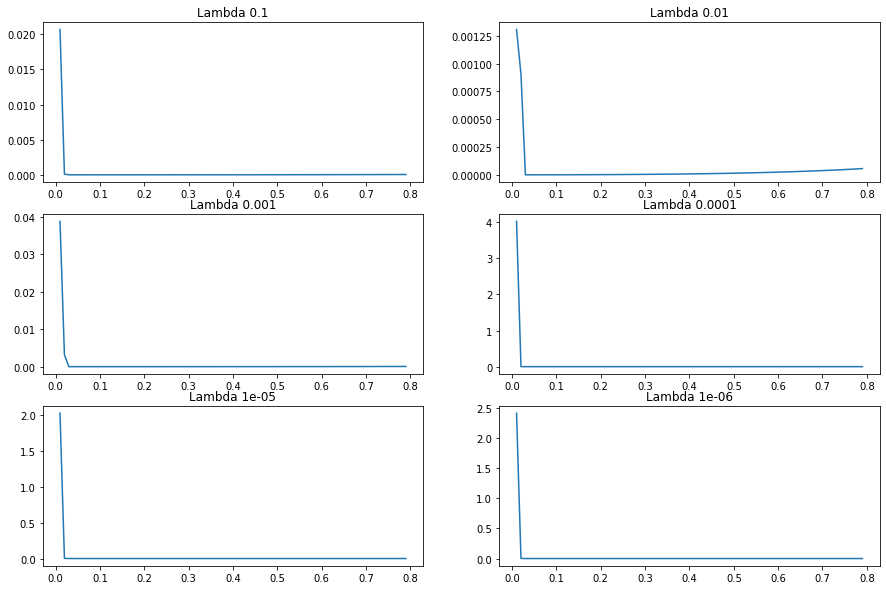

In [34]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix similar to the corrleation matrix value
pmatrix=df.drop(['Close_forcast'], axis=1).corr().round(1).to_numpy()

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 300, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()

In [35]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 300, 0.01, 0.03, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 300, 0.01, 0.03, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[0.89592243]
 [0.04530492]
 [0.23637429]
 [0.75265862]
 [0.64349282]
 [0.84637331]
 [0.64541345]
 [0.74740564]
 [0.8087598 ]
 [0.73887735]
 [0.36253604]
 [0.60719755]
 [0.51206336]
 [0.4208883 ]
 [0.16945092]
 [0.57758365]
 [0.12358011]
 [0.1802443 ]
 [0.83290246]
 [0.68702722]
 [0.71797648]
 [0.51333856]
 [0.78832542]
 [0.67687476]
 [0.38187982]
 [0.72632366]
 [0.10850268]
 [0.31927656]
 [0.05899629]
 [0.24514716]
 [0.76894973]
 [0.78934532]
 [0.23357806]
 [0.43103372]
 [0.92696141]
 [0.7064864 ]
 [0.93411375]
 [0.37068237]
 [0.4714101 ]
 [0.89397908]
 [0.34525532]
 [0.78183825]
 [0.51336639]
 [0.34249874]
 [0.64597333]
 [0.83909369]
 [0.97263593]
 [0.75125984]
 [0.42830324]
 [0.24449782]
 [0.77475936]
 [0.99573885]
 [0.77999376]
 [0.54660965]
 [0.83390573]
 [0.60936832]
 [0.94098189]
 [0.98659379]
 [0.03265756]
 [0.07714479]]
Mean square error of  Regression
3.7533500314890953e-08
Standard Error of the coffecients
0.2887656452453052
0.2649061622327301
0.2636914236584392


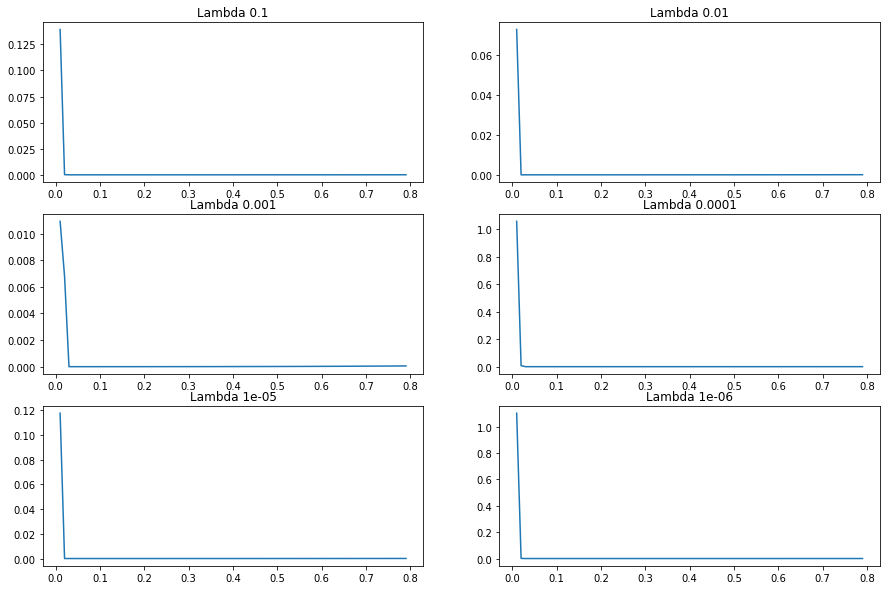

In [36]:
#finding the optimal hyperparamter that is learning rate and regularization constant for CGFLASSO(NEW APPROACH) regression

#building the priormatrix same like Graph Lasso
pmatrix=df.drop(['Close_forcast'], axis=1).corr().to_numpy()
for i in range(0,x_train.shape[1]):
  for j in range(0,x_train.shape[1]):
    if abs(pmatrix[i][j])>0.5:
      pmatrix[i][j]=1
    else:
      pmatrix[i][j]=0

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
sx = 0
sy = 0
for j in lambda_value:
    merror = []
    for i in learning_rate:
        w, b = fitNewApproach(x, y, 300, j, i, pmatrix)
        merror.append(returnMeanSqaure(w, b, x, y))

    axs[sx, sy].plot(learning_rate, merror)
    axs[sx, sy].title.set_text("Lambda {}".format(j))
    sy = sy+1
    if sy % 2 == 0:
        sx = sx+1
        sy = 0

plt.show()


In [37]:
#getting the mse on test dataset on the optimal hyperparameters
w, b = fitNewApproach(x, y, 300, 0.001, 0.03, pmatrix)
singleRunAnalysis(x, y, w, b)
coffecientlist = []
for _ in range(x.shape[1]):
    coffecientlist.append([])

#finding the standard error of the cofficients of the optimal hyperparameters
for _ in range(100):
    w, b = fitNewApproach(x, y, 300, 0.001, 0.03, pmatrix)
    for i in range(x.shape[1]):
        coffecientlist[i].append(w[i][0])

for i in range(x.shape[1]):
    print(np.array(coffecientlist[i]).std())


Coffecients
[[0.2619286 ]
 [0.28248887]
 [0.61856176]
 [0.89361102]
 [0.09117434]
 [0.5961185 ]
 [0.21216693]
 [0.0873645 ]
 [0.57912719]
 [0.422246  ]
 [0.60556217]
 [0.99082287]
 [0.55712478]
 [0.84730397]
 [0.56858464]
 [0.44509508]
 [0.69475148]
 [0.63187622]
 [0.77348782]
 [0.21180213]
 [0.77051864]
 [0.28995777]
 [0.65624502]
 [0.0019684 ]
 [0.9305348 ]
 [0.85687094]
 [0.57311167]
 [0.53596844]
 [0.27408781]
 [0.7841701 ]
 [0.52074672]
 [0.16924744]
 [0.55413936]
 [0.2500834 ]
 [0.73744762]
 [0.47281118]
 [0.38368996]
 [0.66728884]
 [0.97741655]
 [0.23490682]
 [0.11275192]
 [0.9344484 ]
 [0.34129835]
 [0.65544858]
 [0.00938058]
 [0.43475149]
 [0.17725754]
 [0.39679213]
 [0.19810564]
 [0.74135542]
 [0.10738622]
 [0.08170777]
 [0.02157311]
 [0.64319453]
 [0.5868446 ]
 [0.71327779]
 [0.13036315]
 [0.29521338]
 [0.35317515]
 [0.37784923]]
Mean square error of  Regression
5.423498011983384e-08
Standard Error of the coffecients
0.2813200550325975
0.2891771815193949
0.29219512187005103


In [20]:
#finding the standdeviation of the standerror of the coffecients on different priormatrix 
learning_rate = [i/100 for i in range(1, 80)]
stanalysis=[[] for j in range(0,x.shape[1])]
for a in range(0,10):
        coff=np.random.rand()
        epsilon=np.random.uniform(low=0, high=0.05)
        if coff < 0.5:
             epsilon=-1*epsilon
        pmatrix=df.drop(['Close_forcast'], axis=1).corr().to_numpy()
        for i in range(0,x_train.shape[1]):
            for j in range(0,x_train.shape[1]):
                 pmatrix[i][j]=pmatrix[i][j]+epsilon
                 if pmatrix[i][j] > 1:
                      pmatrix[i][j]=1
                 elif pmatrix[i][j] < 0:
                      pmatrix[i][j]=0
    
        lambda_value = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
        pmses=[]
        for j in lambda_value:
            pmses.append([])
            t=len(pmses)-1
            for i in learning_rate:
                w, b = fitNewApproach(x, y, 300, j, i, pmatrix)
                temp=returnMeanSqaure(w, b, x, y)
                pmses[t].append(temp)
        

        rlambda=0
        rlearning=0
        tmin=1e9
        for i in range(0,len(lambda_value)):
             temp=min(pmses[i])
             index=np.where(pmses == temp)[0][0]
             if temp < tmin:
                  tmin=temp
                  rlambda=lambda_value[i]
                  rlearning=index/100
        coffecientlist = []
        for _ in range(x.shape[1]):
             coffecientlist.append([])
        for _ in range(100):
             w, b = fitNewApproach(x, y, 300, rlambda, rlearning, pmatrix)
             for i in range(0,x.shape[1]):
                  coffecientlist[i].append(w[i][0])
        for i in range(0,x.shape[1]):
               stanalysis[i].append(np.array(coffecientlist[i]).std())



for i in range(x.shape[1]):
        print(np.array(stanalysis[i]).std())

0.01132863593436447
0.011709464603597612
0.007874874753948586
0.01058296890280699
0.00640680092964364
0.01768938768539075
0.015910859267459873
0.01651200072778813
0.006510917244585427
0.015403660798700893
0.01752747777433417
0.012041220018203114
0.011546144038117313
0.013173962709650103
0.009069316130904979
0.01200896389577667
0.01041928055442192
0.013207912013813664
0.008212514776278448
0.012541547335847822
0.0095102807283033
0.011363146972236685
0.011569933542894545
0.010239532476944651
0.011545934902467367
0.007877671353260233
0.009265986585892576
0.012277020417034774
0.014462245955649997
0.011067616298063968
0.0075660423501514055
0.016179343934014243
0.0133490153059375
0.014987693461418473
0.008684649193338957
0.010238747416776384
0.01699211651053545
0.012741699593685684
0.01169765591021247
0.014866122862922016
0.010653794612343576
0.013090081028467473
0.008868657019951475
0.016223488844932073
0.011096313488322837
0.010214504081762117
0.011292981655746057
0.014116501647352384
0.010